In [ ]:
from google.colab import files
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
from sklearn.metrics import precision_score

# Configuracion de estilos
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# 1. Subir archivo
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 2. Cargar datos
df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Mostrar informacion basica del dataset
print("Primeras 5 filas del dataset:")
print(df.head())

print("\nInformacion del dataset:")
print(df.info())

print("\nDescripcion estadistica del dataset:")
print(df.describe())

# 3. Preparar datos para el modelo
X = df[['ProductCategory', 'ProductBrand', 'ProductPrice',
        'CustomerAge', 'CustomerGender', 'PurchaseFrequency',
        'CustomerSatisfaction']].copy()
y = df['PurchaseIntent']

# Codificar variables categoricas
X_encoded = pd.get_dummies(X, columns=['ProductCategory', 'ProductBrand'], drop_first=True)

# 4. Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 5. Entrenar modelo regresion logistica
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 6. Visualizacion 1: Distribucion genero vs satisfaccion por compra
plt.figure(figsize=(15, 6))
plt.subplot(2, 2, 1)
df['CustomerGender_cat'] = df['CustomerGender'].map({0: 'Femenino', 1: 'Masculino'})

sns.stripplot(data=df, x='CustomerGender_cat', y='CustomerSatisfaction',
              hue='PurchaseIntent', dodge=True, jitter=0.25, alpha=0.7,
              palette={0: '#cc0000', 1: '#0066cc'})

plt.title('Distribucion: Genero vs Satisfaccion por Compra', pad=15)
plt.xlabel('Genero del Cliente')
plt.ylabel('Satisfaccion del Cliente (1-5)')
plt.yticks([1, 2, 3, 4, 5])
plt.legend(title='Compra', labels=['No', 'Si'])

# 7. Visualizacion 2: Distribucion edad por genero y compra
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 2)
sns.stripplot(data=df, x='CustomerGender_cat', y='CustomerAge',
             hue='PurchaseIntent', dodge=True, jitter=0.2, alpha=0.5, palette={0: '#cc0000', 1: '#0066cc'})

plt.title('Distribucion: Edad vs Genero por compra', pad=15)
plt.xlabel('Genero del Cliente')
plt.ylabel('Edad')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], ['No', 'Si'], title='Compra', loc='upper right')

plt.tight_layout()
plt.show()

# 8. Grafico de proporciones apiladas por genero
plt.figure(figsize=(12, 6))
cross_tab = pd.crosstab(index=df['CustomerGender'],
                        columns=df['PurchaseIntent'],
                        normalize='index') * 100

# Grafico barras apiladas con porcentajes
cross_tab.plot(kind='bar', stacked=True, color=['#ff9999', '#66b3ff'], edgecolor='black')
plt.title('Proporcion de Compras por Genero', pad=15)
plt.xlabel('Genero (0=Femenino, 1=Masculino)')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=0)
plt.legend(['No compro', 'Compro'], title='Decision')
plt.grid(axis='y', alpha=0.3)

# Añadir etiquetas de porcentaje en barras
for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab.loc[x], cross_tab.loc[x].cumsum()):
        plt.text(x=n, y=(y_loc - proportion) + (proportion / 2),
                 s=f'{proportion:.1f}%',
                 color='black',
                 fontsize=10,
                 fontweight='bold')

plt.tight_layout()
plt.show()

# 9. Matriz de correlacion entre variables principales
vars_principales = ['ProductPrice', 'CustomerAge', 'CustomerGender', 'PurchaseFrequency', 'CustomerSatisfaction', 'PurchaseIntent']
corr = df[vars_principales].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlacion de Variables Principales con PurchaseIntent', pad=15)
plt.tight_layout()
plt.show()

# 10. Matriz de confusion para evaluar el modelo
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No Compra', 'Compra'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Prediccion')
ax.set_ylabel('Real')
ax.grid(False)

plt.title('Matriz de Confusion')
plt.show()

# Mostrar reporte de clasificacion con precision, recall y f1-score
print("Reporte de clasificacion:\n")
print(classification_report(y_test, y_pred, target_names=['No Compra', 'Compra']))

# 11. Predecir probabilidades y clases para test
probs = model.predict_proba(X_test)[:, 1]
preds = model.predict(X_test)

# Crear DataFrame con columnas originales para mostrar resultados
results = df.loc[X_test.index, ['ProductCategory', 'ProductBrand', 'ProductPrice']].copy()
results['ProbabilidadCompra'] = probs
results['PrediccionCompra'] = preds
results['CompraReal'] = y_test.values

# Mostrar primeras 10 filas con resultados
print(results.head(10))

# 12. Grafico: Probabilidad promedio de compra por Producto+Marca
results['ProductoMarca'] = results['ProductCategory'] + " " + results['ProductBrand']
prob_promedio = results.groupby('ProductoMarca')['ProbabilidadCompra'].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 7))
prob_promedio.plot(kind='bar')
plt.ylabel('Probabilidad Promedio de Compra')
plt.xlabel('Producto + Marca')
plt.title('Probabilidad Promedio de Compra por Producto y Marca')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 13. Grafico comparativo: Probabilidad predicha vs proporcion real
prob_promedio = results.groupby('ProductoMarca')['ProbabilidadCompra'].mean()
compra_real_promedio = results.groupby('ProductoMarca')['CompraReal'].mean()

df_plot = pd.DataFrame({
    'ProbabilidadPredicha': prob_promedio,
    'ProporcionReal': compra_real_promedio
}).sort_values(by='ProbabilidadPredicha', ascending=False)

n = len(df_plot)
ind = np.arange(n)
width = 0.35

plt.figure(figsize=(16, 7))
plt.bar(ind - width/2, df_plot['ProbabilidadPredicha'], width, label='Probabilidad Predicha', alpha=0.7)
plt.bar(ind + width/2, df_plot['ProporcionReal'], width, label='Proporcion Real de Compra', alpha=0.7, color='orange')
plt.ylabel('Promedio de Compra')
plt.title('Comparacion entre Probabilidad Predicha y Proporcion Real de Compra por Producto+Marca')
plt.xticks(ind, df_plot.index, rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 14. Precision del modelo
precision = precision_score(y_test, y_pred)
print(f"Precision del modelo: {precision:.2f}")


Saving consumer_electronics_sales_data.csv to consumer_electronics_sales_data (23).csv
Primeras 5 filas del dataset:
   ProductID ProductCategory  ProductBrand  ProductPrice  CustomerAge  \
0       5874     Smartphones  Other Brands    312.949668           18   
1       5875   Smart Watches       Samsung    980.389404           35   
2       5876         Tablets       Samsung   2606.718293           63   
3       5877     Smartphones       Samsung    870.395450           63   
4       5878         Tablets          Sony   1798.955875           57   

   CustomerGender  PurchaseFrequency  CustomerSatisfaction  PurchaseIntent  
0               0                  2                     1               0  
1               1                  7                     2               1  
2               0                  1                     5               1  
3               1                 10                     3               1  
4               0                 17                     3 

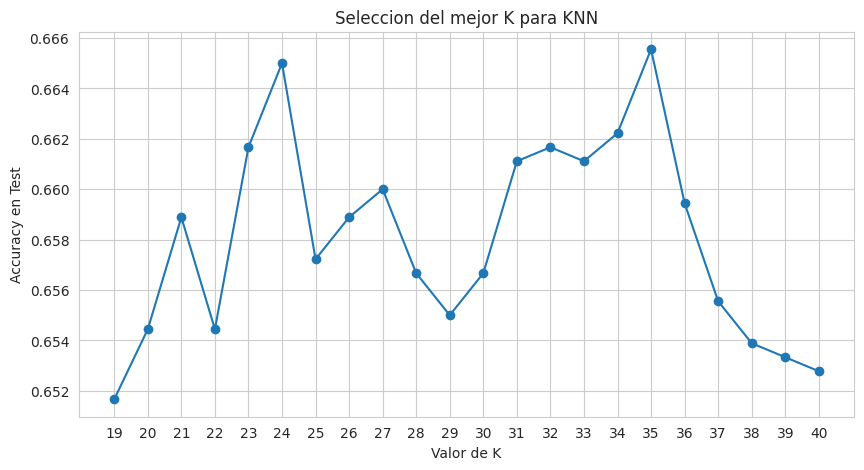

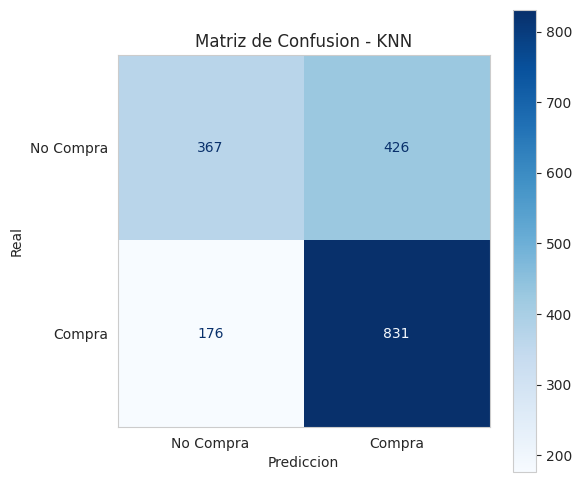

Reporte de clasificacion:

              precision    recall  f1-score   support

   No Compra       0.68      0.46      0.55       793
      Compra       0.66      0.83      0.73      1007

    accuracy                           0.67      1800
   macro avg       0.67      0.64      0.64      1800
weighted avg       0.67      0.67      0.65      1800

     ProductCategory ProductBrand  ProductPrice  PrediccionCompra  CompraReal  \
7940         Tablets           HP   1614.413340                 1           1   
1162     Smartphones           HP   1123.578976                 1           1   
582       Headphones        Apple   2192.783016                 1           1   
4081     Smartphones         Sony   1132.985771                 0           0   
8412   Smart Watches        Apple    736.194786                 0           0   
8730      Headphones      Samsung   1578.351979                 0           0   
5936         Laptops         Sony   2503.307576                 1           1  

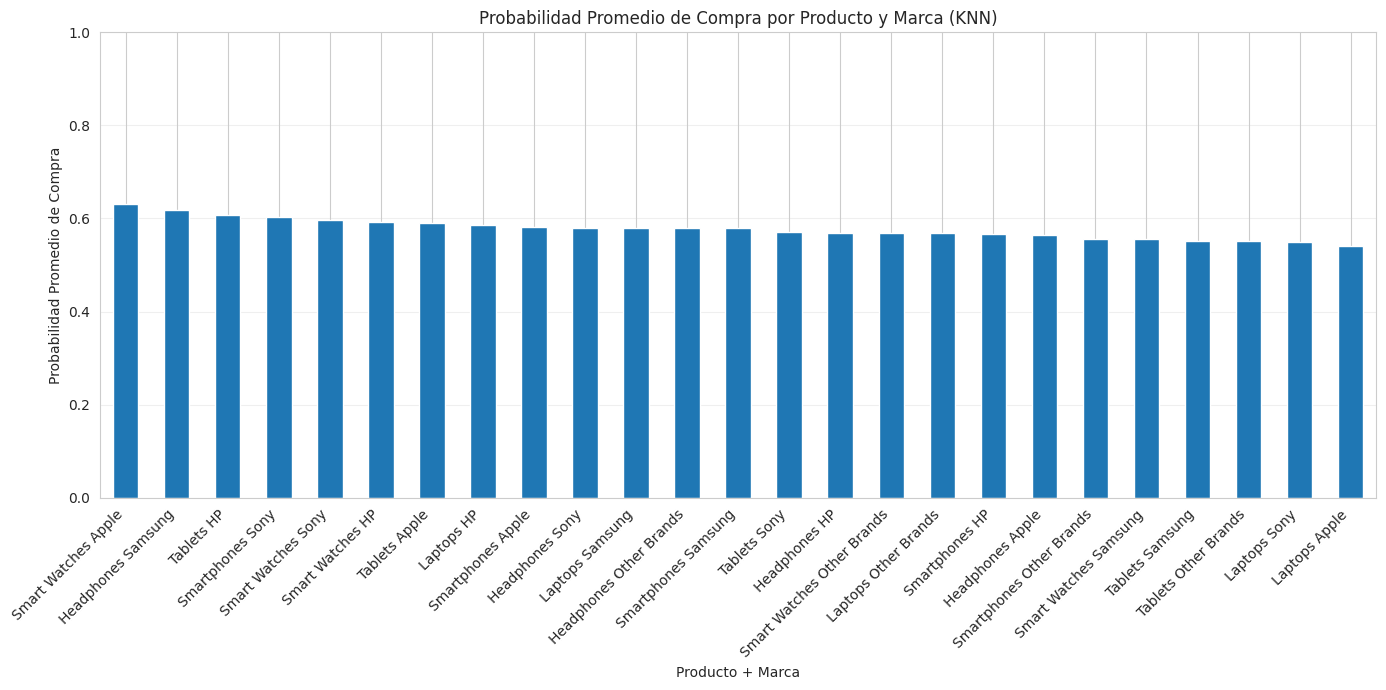

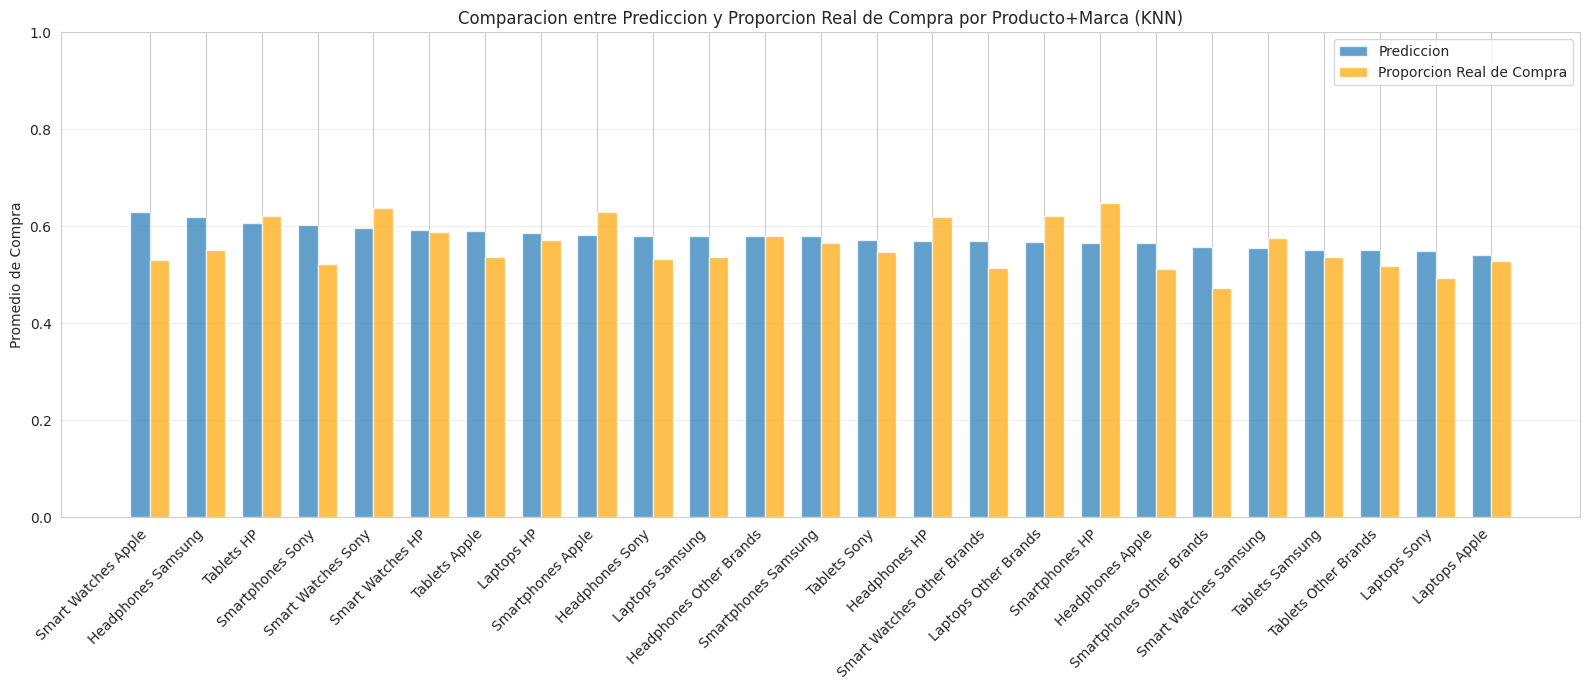

Precision del modelo: 0.66


In [24]:
from google.colab import files
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import seaborn as sns
from sklearn.metrics import precision_score

# Configuracion de estilos
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# 1. Subir archivo
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 2. Cargar datos
df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Mostrar informacion basica del dataset
print("Primeras 5 filas del dataset:")
print(df.head())

print("\nInformacion del dataset:")
print(df.info())

print("\nDescripcion estadistica del dataset:")
print(df.describe())

# 3. Preparar datos para el modelo
X = df[['ProductCategory', 'ProductBrand', 'ProductPrice',
        'CustomerAge', 'CustomerGender', 'PurchaseFrequency',
        'CustomerSatisfaction']].copy()
y = df['PurchaseIntent']

# Codificar variables categoricas
X_encoded = pd.get_dummies(X, columns=['ProductCategory', 'ProductBrand'], drop_first=True)

# 4. Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 5. Encontrar el mejor valor de K con validacion simple (accuracy)
k_values = list(range(19, 41))
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_k = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred_k)
    accuracies.append(acc)

# Mejor K segun accuracy
best_k = k_values[np.argmax(accuracies)]
print(f"\nMejor valor de K: {best_k} con accuracy = {max(accuracies):.4f}")

# Grafico accuracy vs K
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Valor de K')
plt.ylabel('Accuracy en Test')
plt.title('Seleccion del mejor K para KNN')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# 6. Entrenar KNN con el mejor K
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)

# 7. Predicciones con el mejor modelo
y_pred = knn_best.predict(X_test)

# 8. Mostrar matriz de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No Compra', 'Compra'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Prediccion')
ax.set_ylabel('Real')
ax.grid(False)
plt.title('Matriz de Confusion - KNN')
plt.show()

# 9. Mostrar reporte de clasificacion con precision, recall y f1-score
print("Reporte de clasificacion:\n")
print(classification_report(y_test, y_pred, target_names=['No Compra', 'Compra']))

# 10. Crear DataFrame con resultados
results = df.loc[X_test.index, ['ProductCategory', 'ProductBrand', 'ProductPrice']].copy()
results['PrediccionCompra'] = y_pred
results['CompraReal'] = y_test.values

# Nota: KNN no da probabilidades nativamente, pero sklearn tiene predict_proba si usas KNeighborsClassifier, asi que podemos usarlo

if hasattr(knn_best, "predict_proba"):
    probs = knn_best.predict_proba(X_test)[:, 1]
    results['ProbabilidadCompra'] = probs
else:
    results['ProbabilidadCompra'] = np.nan

print(results.head(10))

# 11. Grafico: Probabilidad promedio de compra por Producto+Marca (usando probabilidades si hay)
results['ProductoMarca'] = results['ProductCategory'] + " " + results['ProductBrand']

if results['ProbabilidadCompra'].notna().any():
    prob_promedio = results.groupby('ProductoMarca')['ProbabilidadCompra'].mean().sort_values(ascending=False)
    plt.figure(figsize=(14, 7))
    prob_promedio.plot(kind='bar')
    plt.ylabel('Probabilidad Promedio de Compra')
    plt.xlabel('Producto + Marca')
    plt.title('Probabilidad Promedio de Compra por Producto y Marca (KNN)')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("El modelo KNN no provee probabilidades para graficar.")

# 12. Grafico comparativo: Prediccion vs Compra real (promedio)
compra_real_promedio = results.groupby('ProductoMarca')['CompraReal'].mean()
if results['ProbabilidadCompra'].notna().any():
    prob_promedio = results.groupby('ProductoMarca')['ProbabilidadCompra'].mean()
else:
    prob_promedio = results.groupby('ProductoMarca')['PrediccionCompra'].mean()

df_plot = pd.DataFrame({
    'Prediccion': prob_promedio,
    'ProporcionReal': compra_real_promedio
}).sort_values(by='Prediccion', ascending=False)

n = len(df_plot)
ind = np.arange(n)
width = 0.35

plt.figure(figsize=(16, 7))
plt.bar(ind - width/2, df_plot['Prediccion'], width, label='Prediccion', alpha=0.7)
plt.bar(ind + width/2, df_plot['ProporcionReal'], width, label='Proporcion Real de Compra', alpha=0.7, color='orange')
plt.ylabel('Promedio de Compra')
plt.title('Comparacion entre Prediccion y Proporcion Real de Compra por Producto+Marca (KNN)')
plt.xticks(ind, df_plot.index, rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 13. Precision del modelo
precision = precision_score(y_test, y_pred)
print(f"Precision del modelo: {precision:.2f}")

Saving consumer_electronics_sales_data.csv to consumer_electronics_sales_data (24).csv
Primeras 5 filas del dataset:
   ProductID ProductCategory  ProductBrand  ProductPrice  CustomerAge  \
0       5874     Smartphones  Other Brands    312.949668           18   
1       5875   Smart Watches       Samsung    980.389404           35   
2       5876         Tablets       Samsung   2606.718293           63   
3       5877     Smartphones       Samsung    870.395450           63   
4       5878         Tablets          Sony   1798.955875           57   

   CustomerGender  PurchaseFrequency  CustomerSatisfaction  PurchaseIntent  
0               0                  2                     1               0  
1               1                  7                     2               1  
2               0                  1                     5               1  
3               1                 10                     3               1  
4               0                 17                     3 

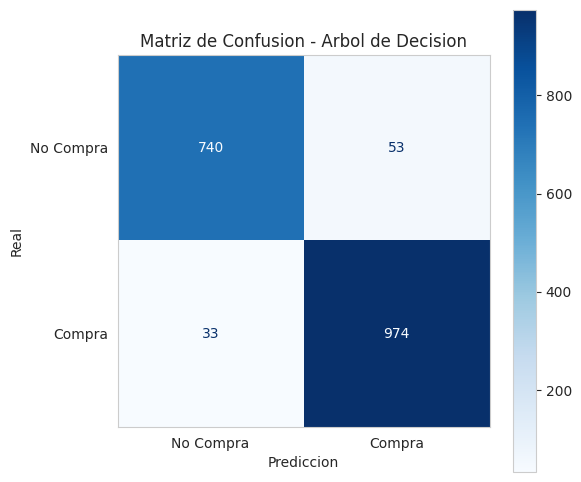

Reporte de clasificacion:

              precision    recall  f1-score   support

   No Compra       0.96      0.93      0.95       793
      Compra       0.95      0.97      0.96      1007

    accuracy                           0.95      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.95      0.95      0.95      1800

Precision del modelo (Arbol de Decision): 0.95
     ProductCategory ProductBrand  ProductPrice  PrediccionCompra  CompraReal  \
7940         Tablets           HP   1614.413340                 1           1   
1162     Smartphones           HP   1123.578976                 1           1   
582       Headphones        Apple   2192.783016                 1           1   
4081     Smartphones         Sony   1132.985771                 0           0   
8412   Smart Watches        Apple    736.194786                 0           0   
8730      Headphones      Samsung   1578.351979                 0           0   
5936         Laptops         Son

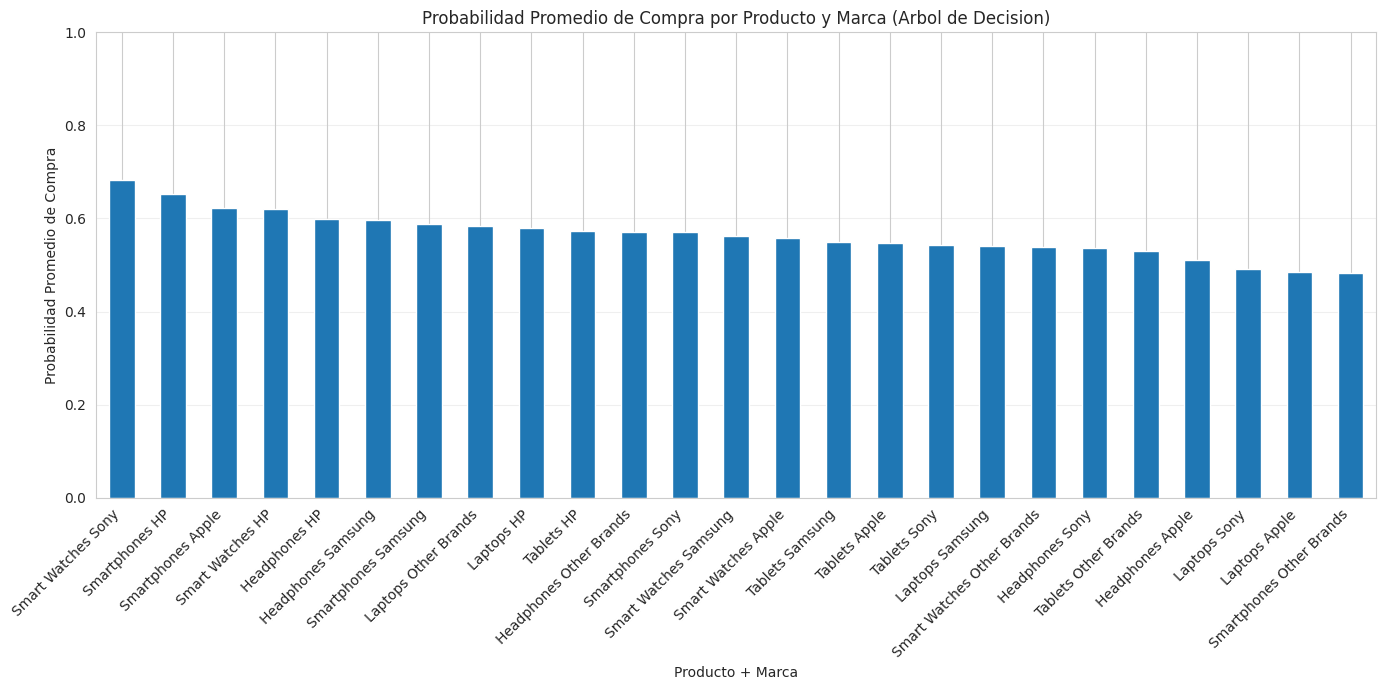

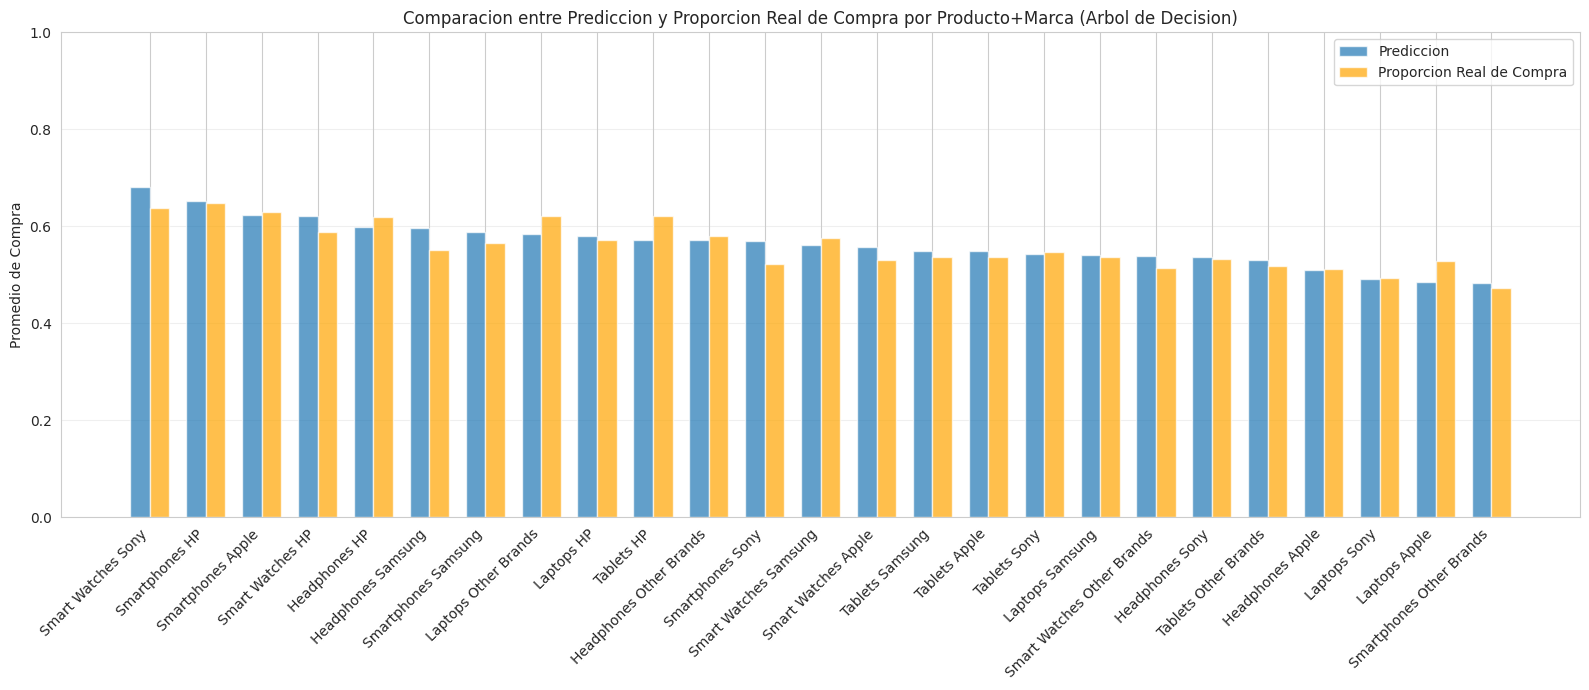

Precision del modelo: 0.95


In [25]:
from google.colab import files
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score
import seaborn as sns

# Configuracion de estilos
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# 1. Subir archivo
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 2. Cargar datos
df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Mostrar informacion basica del dataset
print("Primeras 5 filas del dataset:")
print(df.head())

print("\nInformacion del dataset:")
print(df.info())

print("\nDescripcion estadistica del dataset:")
print(df.describe())

# 3. Preparar datos para el modelo
X = df[['ProductCategory', 'ProductBrand', 'ProductPrice',
        'CustomerAge', 'CustomerGender', 'PurchaseFrequency',
        'CustomerSatisfaction']].copy()
y = df['PurchaseIntent']

# Codificar variables categoricas
X_encoded = pd.get_dummies(X, columns=['ProductCategory', 'ProductBrand'], drop_first=True)

# 4. Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 5. Entrenar modelo Arbol de Decision
tree = DecisionTreeClassifier(random_state=42, max_depth=5)
tree.fit(X_train, y_train)

# 6. Predicciones
y_pred = tree.predict(X_test)

# 7. Mostrar matriz de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No Compra', 'Compra'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Prediccion')
ax.set_ylabel('Real')
ax.grid(False)
plt.title('Matriz de Confusion - Arbol de Decision')
plt.show()

# 8. Reporte de clasificacion
print("Reporte de clasificacion:\n")
print(classification_report(y_test, y_pred, target_names=['No Compra', 'Compra']))

# 9. Precision del modelo
precision = precision_score(y_test, y_pred)
print(f"Precision del modelo (Arbol de Decision): {precision:.2f}")

# 10. Crear DataFrame con resultados
results = df.loc[X_test.index, ['ProductCategory', 'ProductBrand', 'ProductPrice']].copy()
results['PrediccionCompra'] = y_pred
results['CompraReal'] = y_test.values

# Probabilidades con predict_proba
if hasattr(tree, "predict_proba"):
    probs = tree.predict_proba(X_test)[:, 1]
    results['ProbabilidadCompra'] = probs
else:
    results['ProbabilidadCompra'] = np.nan

print(results.head(10))

# 11. Grafico: Probabilidad promedio de compra por Producto+Marca
results['ProductoMarca'] = results['ProductCategory'] + " " + results['ProductBrand']

if results['ProbabilidadCompra'].notna().any():
    prob_promedio = results.groupby('ProductoMarca')['ProbabilidadCompra'].mean().sort_values(ascending=False)
    plt.figure(figsize=(14, 7))
    prob_promedio.plot(kind='bar')
    plt.ylabel('Probabilidad Promedio de Compra')
    plt.xlabel('Producto + Marca')
    plt.title('Probabilidad Promedio de Compra por Producto y Marca (Arbol de Decision)')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("El modelo Arbol de Decision no provee probabilidades para graficar.")

# 12. Grafico comparativo: Prediccion vs Compra real (promedio)
compra_real_promedio = results.groupby('ProductoMarca')['CompraReal'].mean()
if results['ProbabilidadCompra'].notna().any():
    prob_promedio = results.groupby('ProductoMarca')['ProbabilidadCompra'].mean()
else:
    prob_promedio = results.groupby('ProductoMarca')['PrediccionCompra'].mean()

df_plot = pd.DataFrame({
    'Prediccion': prob_promedio,
    'ProporcionReal': compra_real_promedio
}).sort_values(by='Prediccion', ascending=False)

n = len(df_plot)
ind = np.arange(n)
width = 0.35

plt.figure(figsize=(16, 7))
plt.bar(ind - width/2, df_plot['Prediccion'], width, label='Prediccion', alpha=0.7)
plt.bar(ind + width/2, df_plot['ProporcionReal'], width, label='Proporcion Real de Compra', alpha=0.7, color='orange')
plt.ylabel('Promedio de Compra')
plt.title('Comparacion entre Prediccion y Proporcion Real de Compra por Producto+Marca (Arbol de Decision)')
plt.xticks(ind, df_plot.index, rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 13. Precision del modelo
precision = precision_score(y_test, y_pred)
print(f"Precision del modelo: {precision:.2f}")